# Agent 3: DB Reader
As a key component in the multi-agent system, the **`DB Reader`** agent is responsible for extracting relevant data from historical databases to provide accurate input data for anomaly detection and predictive analysis.

In [1]:
# load environment variables from the .env file
from dotenv import load_dotenv

load_dotenv()

True

## Define user tools

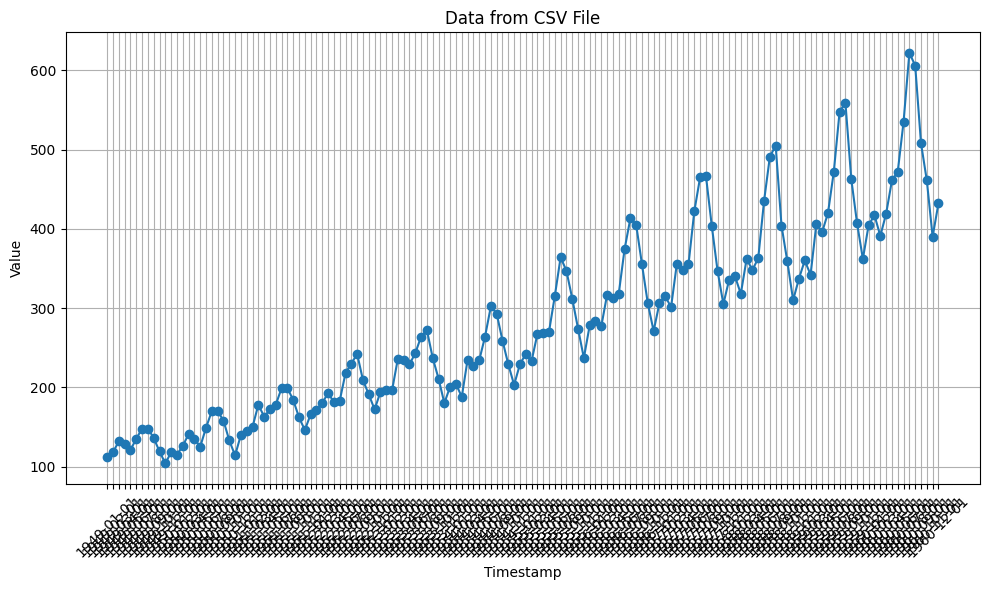

In [2]:
import json
import sqlite3
import pandas as pd
from typing import Literal
from datetime import datetime
import helper


def fetch_data(table_name: Literal['intrusion_attempts', 'incident_detection_rate']) -> str:
    """
    Fetch data from a specified SQLite database table, save it as a CSV file, and return the status and file path in JSON format.

    :param table_name: The name of the table to fetch data from. Must be one of: 'intrusion_attempts' or 'incident_detection_rate'.
    :rtype: Literal['intrusion_attempts', 'incident_detection_rate']

    :return: A JSON string containing the status of the operation and the CSV file path (on success) or an error message (on failure).
    :rtype: str
    """
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect('./database/cyber_data.db')

        # Read all data from the intrusion_attempts table into a DataFrame
        intrusion_attempts = pd.read_sql_query(
            f"SELECT * FROM {table_name}", conn)

        # Save the DataFrame to a CSV file
        current_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        csv_path = f'./data/{table_name}_{current_timestamp}.csv'
        intrusion_attempts.to_csv(csv_path, index=False)

        # Close the connection
        conn.close()

        return json.dumps({"success": True,
                           "message": csv_path})
    except Exception as e:
        return json.dumps({"success": False,
                           "message": f"An error occurred: {e}"})


# Example usage
data_info = fetch_data('intrusion_attempts')  # incident_detection_rate
data_dict = json.loads(data_info)
if data_dict['success']:
    helper.read_and_plot_csv(data_dict['message'])

## Create Agent

In [3]:
import os
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential


project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(), conn_str=os.environ["AIPROJECT_CONNECTION_STRING"]
)

In [4]:
from typing import Any, Set, Callable
from azure.ai.projects.models import FunctionTool

user_functions: Set[Callable[..., Any]] = {fetch_data}
functions = FunctionTool(functions=user_functions)
print(functions.definitions)

[{'type': 'function', 'function': {'name': 'fetch_data', 'description': 'Fetch data from a specified SQLite database table, save it as a CSV file, and return the status and file path in JSON format.', 'parameters': {'type': 'object', 'properties': {'table_name': {'type': 'string', 'description': "The name of the table to fetch data from. Must be one of: 'intrusion_attempts' or 'incident_detection_rate'."}}, 'required': ['table_name']}}}]


In [5]:
# The CodeInterpreterTool needs to be included in creation of the agent
db_reader = project_client.agents.create_agent(
    model=os.environ["CHAT_MODEL"],
    name="db_reader",
    description="This agent fetches data from a specified SQLite database table, saves it as a CSV file, and returns the status and file path in JSON format.",
    instructions="Hello, you are helpful assistant.",
    tools=functions.definitions,
    # Parameters
    temperature=0.7,
    top_p=0.95,
    # Metadata
    metadata={"group": "internet_threat_analysis"},
)

print(f"Created agent, agent ID: {db_reader.id}")

Created agent, agent ID: asst_y0dQ67aZWZyP0GTZI5Ivjqfa


In [8]:
import time
from azure.ai.projects.models import RequiredFunctionToolCall, SubmitToolOutputsAction, ToolOutput


thread = project_client.agents.create_thread()
print(f"Created thread, ID: {thread.id}")

# Create message to thread
message = project_client.agents.create_message(
    thread_id=thread.id, role="user", content="Hello, get the intrution attemps data."
)
print(f"Created message, ID: {message.id}")

# Create and process assistant run in thread with tools
run = project_client.agents.create_run(
    thread_id=thread.id, assistant_id=db_reader.id)
print(f"Created run, ID: {run.id}")

while run.status in ["queued", "in_progress", "requires_action"]:
    time.sleep(1)
    run = project_client.agents.get_run(thread_id=thread.id, run_id=run.id)

    if run.status == "requires_action" and isinstance(run.required_action, SubmitToolOutputsAction):
        tool_calls = run.required_action.submit_tool_outputs.tool_calls
        if not tool_calls:
            print("No tool calls provided - cancelling run")
            project_client.agents.cancel_run(
                thread_id=thread.id, run_id=run.id)
            break

        tool_outputs = []
        for tool_call in tool_calls:
            if isinstance(tool_call, RequiredFunctionToolCall):
                try:
                    print(f"Executing tool call: {tool_call}")
                    output = functions.execute(tool_call)
                    tool_outputs.append(
                        ToolOutput(
                            tool_call_id=tool_call.id,
                            output=output,
                        )
                    )
                except Exception as e:
                    print(f"Error executing tool_call {tool_call.id}: {e}")

        print(f"Tool outputs: {tool_outputs}")
        if tool_outputs:
            project_client.agents.submit_tool_outputs_to_run(
                thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs
            )

    print(f"Current run status: {run.status}")

print(f"Run completed with status: {run.status}")

Created thread, ID: thread_oYiei09b87zdHM4fj7dKh9wf
Created message, ID: msg_agn4DVrboaP0H3V537MKgM2Q
Created run, ID: run_fyZwRklreSxmkwZMUkWqCyKU
Executing tool call: {'id': 'call_PhXFVriTCPULoiVuYgXZJUlS', 'type': 'function', 'function': {'name': 'fetch_data', 'arguments': '{"table_name":"intrusion_attempts"}'}}
Tool outputs: [{'tool_call_id': 'call_PhXFVriTCPULoiVuYgXZJUlS', 'output': '{"success": true, "message": "./data/intrusion_attempts_20250116_110658.csv"}'}]
Current run status: RunStatus.REQUIRES_ACTION
Current run status: RunStatus.COMPLETED
Run completed with status: RunStatus.COMPLETED


In [9]:
from IPython.display import Markdown, display
import helper

messages = project_client.agents.list_messages(thread_id=thread.id)

display(Markdown(helper.get_conversation_md(messages)))

# Conversation
___
### **User** (2025-01-16 11:06:56 CST)
Hello, get the intrution attemps data.
___
### **Assistant** (2025-01-16 11:07:00 CST)
The intrusion attempts data has been successfully fetched and saved as a CSV file. You can download it [here](./data/intrusion_attempts_20250116_110658.csv).
___